In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from sklearn import model_selection
from sklearn import metrics
from IPython.display import display
import torch.utils.data as tdata
import os
import time

# Задание 1

In [2]:
def func(x, i):
    x.requires_grad_(True)
    f = torch.log(torch.exp(x[i])/torch.sum(torch.exp(x)))
    f.backward()
    return x.grad

In [3]:
func(torch.tensor([1., 2., 3.]), 1)

tensor([-0.0900,  0.7553, -0.6652])

# Задание 5

In [4]:
os.listdir("data")

['seg_pred', 'seg_test', 'seg_train']

In [5]:
os.listdir("data/seg_train/seg_train")

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [6]:
data_path_format = 'data/seg_{0}/seg_{0}'

In [7]:
np.random.seed(5315)
torch.manual_seed(9784)

In [8]:
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

In [10]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: data/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )}


In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [13]:
print(len(val_indices))

1404


In [14]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [15]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: data/seg_test/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'train': <torch.utils.data.dataset.Subset object at 0x0000020276D5C220>, 'validation': <torch.utils.data.dataset.Subset object at 0x0000020276D5C820>}


In [16]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [17]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [18]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)

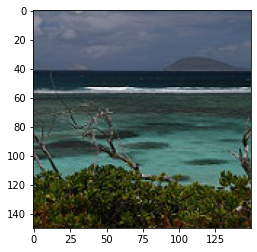

In [19]:
imshow(image_datasets['train'][8555][0]) # 5946

In [20]:
device = torch.device('cuda')

In [21]:
def conv(in_, out_):
    return nn.Sequential(
        nn.Conv2d(in_, out_, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_),
        nn.MaxPool2d(2,2)
    )
def fc(in_, out_):
    return nn.Sequential(
        nn.Linear(in_, out_),
        nn.Tanh(),
        nn.BatchNorm1d(out_)
    )
    
class ConvNN(nn.Module): 
    def __init__(self): 
        super(ConvNN, self).__init__()
        self.batch_norm = torch.nn.BatchNorm2d(3)
           
        self.conv = nn.Sequential(
                conv(3, 16),
                conv(16, 32),
                conv(32, 64),
                conv(64, 128),
                conv(128, 256)
        )
        self.fc = nn.Sequential(
                fc(4096, 256),
                fc(256, 64)
        )
        self.clf   = torch.nn.Linear(64, 8)
    def forward(self, x):
        x = self.batch_norm(x)
        x = self.conv(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc(x)
        x = self.clf(x)
        return x

In [22]:
ptr = ConvNN()
ptr.to(device)

ConvNN(
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [23]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [24]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)

In [25]:
start = time.time()

In [26]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.1088318183452268
Epoch 0, iteration 315 training_loss 0.8556333376636988
Epoch 0, iteration 473 training_loss 0.8092722749408288
Epoch 0, iteration 631 training_loss 0.7125283245798908
Epoch 0, iteration 789 training_loss 0.713761559109899
Epoch 0, val_loss 0.6343322609635916, accuracy = 0.7784900284900285
Epoch 1, iteration 157 training_loss 0.6091801321393326
Epoch 1, iteration 315 training_loss 0.6317910435079019
Epoch 1, iteration 473 training_loss 0.6225558742880821
Epoch 1, iteration 631 training_loss 0.5919950023953673
Epoch 1, iteration 789 training_loss 0.5680476368605336
Epoch 1, val_loss 0.4871563967317343, accuracy = 0.8169515669515669
Epoch 2, iteration 157 training_loss 0.5013756346947784
Epoch 2, iteration 315 training_loss 0.5058890184081053
Epoch 2, iteration 473 training_loss 0.512317631393671
Epoch 2, iteration 631 training_loss 0.5401045788032345
Epoch 2, iteration 789 training_loss 0.5146363798198821
Epoch 2, val_loss 0.467653

In [27]:
end = time.time()
print(end - start)

183.11219024658203


In [28]:
xx, yy = next(iter(image_dataloaders['validation']))

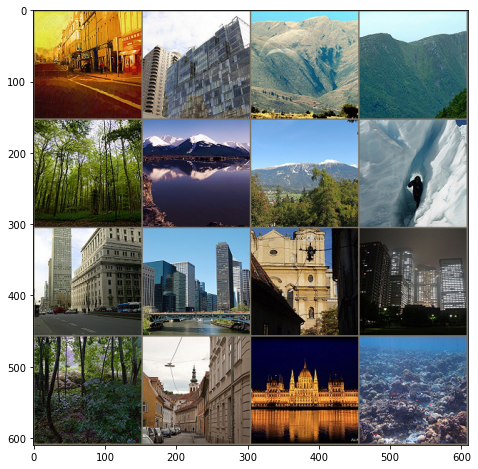

Predictions:  ['street', 'buildings', 'mountain', 'mountain', 'forest', 'mountain', 'mountain', 'glacier', 'street', 'buildings', 'buildings', 'buildings', 'forest', 'street', 'buildings', 'mountain']
Reality:  ['street', 'buildings', 'mountain', 'mountain', 'forest', 'mountain', 'mountain', 'glacier', 'buildings', 'buildings', 'buildings', 'buildings', 'forest', 'street', 'buildings', 'sea']


In [29]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print('Predictions: ', predicted_classes)
print('Reality: ', actual_classes)

In [30]:
all_preds = []
correct_preds = []
ptr.eval()
for xx, yy in image_dataloaders['test']:
    xx = xx.to(device)
    output = ptr(xx)
    all_preds.extend(output.argmax(1).tolist())
    correct_preds.extend(yy.tolist())

In [31]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [32]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.88      0.78      0.83       437
      forest       0.95      0.97      0.96       474
     glacier       0.82      0.80      0.81       553
    mountain       0.77      0.87      0.82       525
         sea       0.90      0.80      0.85       510
      street       0.83      0.91      0.87       501

    accuracy                           0.85      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.85      0.85      3000



In [33]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,339,7,4,3,6,78
forest,2,462,1,4,3,2
glacier,0,3,440,84,21,5
mountain,6,2,42,459,14,2
sea,9,4,44,41,408,4
street,28,6,3,5,3,456
